# Intro

Here we use ALL perturbed cell-types.
This is done when we generate the pseudobulks by sampling from both perturbed or non-perturbed cells within each sample.

This data QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.

This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


In [2]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'sc_preprocessing.sc_preprocess' from '/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/2_make_pseudobulks/../../sc_preprocessing/sc_preprocess.py'>

# Parameters

In [3]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_covid_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_covid/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/covid/"



#####################
### set the study ###
#####################

res_name = "all-covid"
in_name = "covid_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [4]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# only keep the healthy patients
#adata = adata[np.where(adata.obs["Status"] == "Healthy")]


In [5]:
adata.obs

,Admission,ClusterID,DPS,DTF,Donor_full,HLA1,IFN1,Sex,Status,Ventilated,...,percent_rps,percent_rrna,seurat_clusters,singler,names_merged,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
covid_555_1.3,ICU,19,9,9,C1 A,-0.044271,0.086385,M,COVID,NonVent,...,0.663507,55.829384,18,B_cell,PB,213,213,221.804581,6.558198,2.956746
covid_555_1.11,ICU,30,9,9,C1 A,-0.071987,0.064483,M,COVID,NonVent,...,0.686106,36.277874,29,NK_cell,PB,351,351,340.707031,10.302532,3.023868
covid_555_1.13,ICU,10,9,9,C1 A,-0.015134,0.091744,M,COVID,NonVent,...,2.344455,29.936880,9,T_cells,B,384,384,373.315155,11.285774,3.023123
covid_555_1.14,ICU,4,9,9,C1 A,-0.019934,0.124215,M,COVID,NonVent,...,0.872093,36.918606,3,Monocyte,CD14_monocyte,392,392,379.235016,24.238476,6.391413
covid_555_1.15,ICU,4,9,9,C1 A,-0.016222,0.143519,M,COVID,NonVent,...,0.858779,45.419846,3,Monocyte,CD14_monocyte,401,401,377.998352,10.075759,2.665556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIP045.2543,N/A,7,0,0,H6,0.588374,0.092001,M,Healthy,Healthy,...,2.867442,10.797968,6,Monocyte,CD14_monocyte,1080,1080,926.531433,28.524797,3.078665
HIP045.2544,N/A,21,0,0,H6,1.295145,0.045697,M,Healthy,Healthy,...,4.929000,12.738940,20,Monocyte,DC,1031,1031,907.909729,24.471142,2.695328
HIP045.2545,N/A,21,0,0,H6,0.892457,0.062819,M,Healthy,Healthy,...,4.978015,14.400126,20,T_cells,DC,1021,1021,878.305176,22.454103,2.556526
HIP045.2546,N/A,11,0,0,H6,0.020954,0.036953,M,Healthy,Healthy,...,2.998950,14.574899,10,Monocyte,CD16_monocyte,1063,1063,902.209534,24.663647,2.733694


In [8]:
# format metadata


adata.obs['CellType'] = adata.obs['names_merged'].tolist()
adata.obs['scpred_CellType'] = adata.obs['names_merged'].tolist()
adata.obs['sample_id'] = adata.obs['Donor_full'].tolist()
adata.obs['stim'] = ["CTRL"]*adata.obs.shape[0]
idx_covid = np.where(adata.obs["Status"] == "COVID")[0]
adata.obs["stim"][idx_covid] = "STIM"

adata.var['gene_ids'] = adata.var.index.tolist()


<ipython-input-8-5b6488ad2dce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["stim"][idx_covid] = "STIM"


### Preprocess

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


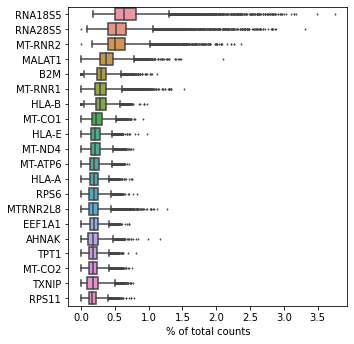

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [10]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


CD14_monocyte    10332
CD4_T             8393
NK                6857
CD8_T             6762
B                 4998
PB                2049
CD16_monocyte     1348
RBC                859
Granulocyte        831
Platelet           527
DC                 456
gdT                448
pDC                234
Name: scpred_CellType, dtype: int64

In [11]:
# write out data for BP and cibersort
dense_matrix = adata.X

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [12]:
dense_matrix.shape

(44094, 26361)

# Plot Data

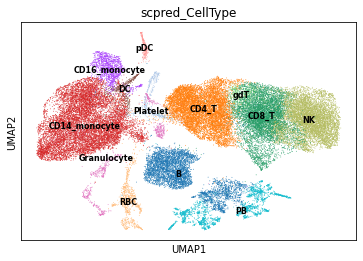

In [13]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [14]:
# we are going to combine a few cell types
tab = adata.obs.groupby(['scpred_CellType', 'seurat_clusters']).size()

tab.unstack()

seurat_clusters,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
scpred_CellType,,,,,,,,,,,,,,,,,,,,,
B,0,0,0,0,0,3679,0,0,0,1319,...,0,0,0,0,0,0,0,0,0,0
CD4_T,0,0,4098,0,3837,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CD8_T,0,5440,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CD14_monocyte,0,0,0,4056,0,0,2637,2200,1439,0,...,0,0,0,0,0,0,0,0,0,0
CD16_monocyte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,90,0
DC,0,0,0,0,0,0,0,0,0,0,...,456,0,0,0,0,0,0,0,0,0
Granulocyte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,324,301,0,206,0,0
NK,5791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PB,0,0,0,0,0,0,0,0,0,0,...,0,445,0,420,0,0,0,0,0,84


In [15]:
adata.obs["sample_id"].value_counts()


C3      6523
H4      5135
C1 B    4991
C4      3678
C7      3359
C1 A    3349
H5      3145
C5      2504
H3      2305
H1      2098
H6      1995
H2      1936
C2      1724
C6      1352
Name: sample_id, dtype: int64

In [16]:
adata.obs

,Admission,ClusterID,DPS,DTF,Donor_full,HLA1,IFN1,Sex,Status,Ventilated,...,names_merged,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
covid_555_1.3,ICU,19,9,9,C1 A,-0.044271,0.086385,M,COVID,NonVent,...,PB,213,213,221.804581,6.558198,2.956746,PB,PB,C1 A,STIM
covid_555_1.11,ICU,30,9,9,C1 A,-0.071987,0.064483,M,COVID,NonVent,...,PB,351,351,340.707031,10.302532,3.023868,PB,PB,C1 A,STIM
covid_555_1.13,ICU,10,9,9,C1 A,-0.015134,0.091744,M,COVID,NonVent,...,B,384,384,373.315155,11.285774,3.023123,B,B,C1 A,STIM
covid_555_1.14,ICU,4,9,9,C1 A,-0.019934,0.124215,M,COVID,NonVent,...,CD14_monocyte,392,392,379.235016,24.238476,6.391413,CD14_monocyte,CD14_monocyte,C1 A,STIM
covid_555_1.15,ICU,4,9,9,C1 A,-0.016222,0.143519,M,COVID,NonVent,...,CD14_monocyte,401,401,377.998352,10.075759,2.665556,CD14_monocyte,CD14_monocyte,C1 A,STIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIP045.2543,N/A,7,0,0,H6,0.588374,0.092001,M,Healthy,Healthy,...,CD14_monocyte,1080,1080,926.531433,28.524797,3.078665,CD14_monocyte,CD14_monocyte,H6,CTRL
HIP045.2544,N/A,21,0,0,H6,1.295145,0.045697,M,Healthy,Healthy,...,DC,1031,1031,907.909729,24.471142,2.695328,DC,DC,H6,CTRL
HIP045.2545,N/A,21,0,0,H6,0.892457,0.062819,M,Healthy,Healthy,...,DC,1021,1021,878.305176,22.454103,2.556526,DC,DC,H6,CTRL
HIP045.2546,N/A,11,0,0,H6,0.020954,0.036953,M,Healthy,Healthy,...,CD16_monocyte,1063,1063,902.209534,24.663647,2.733694,CD16_monocyte,CD16_monocyte,H6,CTRL


In [17]:
adata.obs["scpred_CellType"].unique()

['PB', 'B', 'CD14_monocyte', 'CD8_T', 'RBC', ..., 'Granulocyte', 'CD16_monocyte', 'gdT', 'pDC', 'DC']
Length: 13
Categories (13, object): ['B', 'CD4_T', 'CD8_T', 'CD14_monocyte', ..., 'Platelet', 'RBC', 'gdT', 'pDC']

### now split test and train cells

In [18]:
pd.set_option('display.max_rows', 160)

# generate cell-type specific split
adata.obs["isTraining"] = "Train"


stim_idx = np.where(adata.obs.stim == "STIM")[0]
adata.obs["isTraining"][stim_idx] = "Test"

tab = adata.obs.groupby(['stim', 'isTraining']).size()

tab.unstack()

<ipython-input-18-48f360ee2621>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][stim_idx] = "Test"


isTraining,Test,Train
stim,,
CTRL,0,16614
STIM,27480,0


In [19]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,C1 A,C1 B,C2,C3,C4,C5,C6,C7,H1,H2,H3,H4,H5,H6
isTraining,,,,,,,,,,,,,,
Test,3349,4991,1724,6523,3678,2504,1352,3359,0,0,0,0,0,0
Train,0,0,0,0,0,0,0,0,2098,1936,2305,5135,3145,1995


## Make pseudobulks

In [20]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
sample_order = ['C1 A', 'C1 B', 'C3', 'C4', 'C7', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']
stim_order = ['CTRL', 'STIM']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_samp in sample_order:
  for curr_stim in stim_order:
      for curr_train in train_order:

        print(f"running {curr_samp} {curr_stim} {curr_train}")


        # make the pseudobulks
        subset_idx = np.where(np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.stim == curr_stim))[0]
        if len(subset_idx) == 0:
            continue
        
        temp_adata = adata[subset_idx]

        print("make_prop_and_sum")
        prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(temp_adata, 
                                                                                num_samples=1000, 
                                                                                num_cells=num_cells,
                                                                                use_true_prop=False,
                                                                                cell_noise=cell_noise,
                                                                                useSampleNoise=False)

        # get the single cell type proportions
        print("get_single_celltype_prop_matrix")
        ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100,
                                                                    cell_order=cell_order)

        # now get the cell-type specific pseudobulks
        print("use_prop_make_sum")
        prop_df_sc, pseudobulks_df_sc, _ = sc_preprocess.use_prop_make_sum(temp_adata,  
                                                                            num_cells=num_cells, 
                                                                            props_vec=ct_prop_df, 
                                                                            cell_noise=cell_noise,
                                                                            sample_noise=None,
                                                                            useSampleNoise=False)

        # put them together
        print("concat")        
        prop_df = pd.concat([prop_df,prop_df_sc])
        pseudobulks_df = pd.concat([pseudobulks_df, pseudobulks_df_sc])

        # make the proportions instead of cell counts
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
        pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
        prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")

        print("write")        
        pseudobulk_path = Path(pseudobulk_file)
        prop_path = Path(prop_file)
        pickle.dump( prop_df, open( prop_path, "wb" ) )
        pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )





running C1 A CTRL Train
running C1 A CTRL Test
running C1 A STIM Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
concat
write
running C1 A STIM Test
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
concat
write
running C1 B CTRL Train
running C1 B CTRL Test
running C1 B STIM Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
concat
write
running C1 B STIM Test
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
concat
write
running C3 CTRL Train
running C3 CTRL Test
running C3 STIM Train
make_prop_and_sum
0
100
200
300
400
500

KeyboardInterrupt: 